# Gate Diagnostics
Module Imports

In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import module_path
import sys
#add modules to path
modules: str = module_path.add_module_path()
sys.path.append(modules)
import gate
import file_io
import simulation_setup as setup
import composite_systems as systems
import state_labeling as lbl

Set up simulation parameters

In [2]:
pulse_lbls: list[str] = ['CZ-400ns'] #, 'CZ-130ns',
               # 'CZ-400ns']
configs = setup.setup_sim_from_configs(pulse_lbls=pulse_lbls)

In [3]:
len(configs)
configs[1].keys()

dict_keys(['CZ-400ns'])

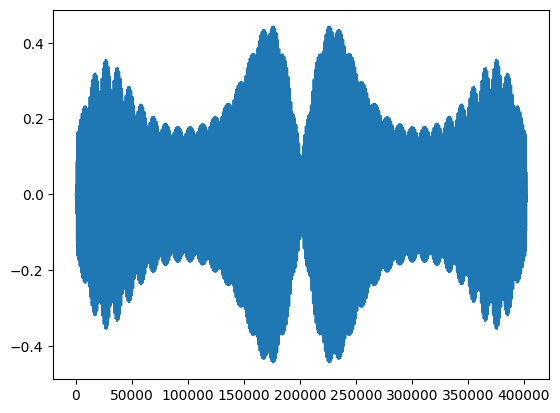

In [14]:
pulses: dict[str, setup.PulseProfile] = {pulse_lbl: configs[1][pulse_lbl]
                                         for pulse_lbl in pulse_lbls}

pulse = pulses['CZ-400ns'].pulse
plt.plot(pulse)

KeyboardInterrupt: 

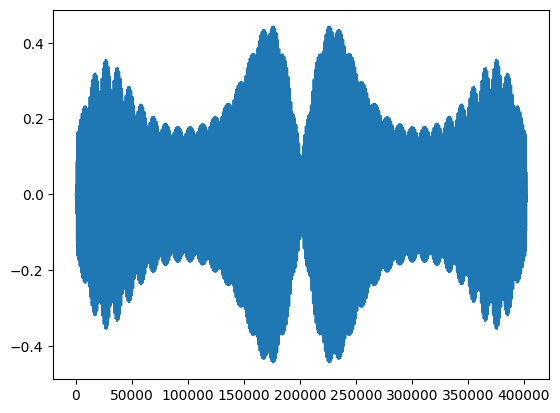

In [13]:

state_trajectories: dict[str, dict[str, np.ndarray[qt.Qobj]]] = {}

for pulse_lbl, pulse in pulses.items():
    pulse_gate = gate.profile_gate(pulse_lbl, pulse)
    state_trajectories[pulse_lbl] = pulse_gate.trajectories
    del pulse_gate

#gates: dict[str, gate.GateProfile] = {pulse_lbl: gate.profile_gate(pulse_lbl, pulse)
 #                                     for pulse_lbl, pulse in pulses.items()}
#state_vector_trajectories = {pulse_lbl: gates[pulse_lbl].trajectories 
#                             for pulse_lbl in gates}
# def get_coords(gate: gate.GateProfile, init_state: str) -> np.ndarray[complex]:
#     comp_states = ['ggg', 'geg', 'egg', 'eeg']
#     gate_ct = gate.circuit
#     state_vecs, state_coords = lbl.get_dressed_comp_states(gate_ct, 2)
#     traj = gate.trajectories[init_state]
#     coords: np.ndarray[complex] = np.empty(shape=[len(traj),4], dtype=complex)
#     for i, rho in enumerate(traj):
#         if rho.type != 'oper':
#             rho = rho * rho.dag()
#         for j, state in comp_states:
#             n, m, k = gate.str_to_tuple(state)
#             c_state = state_vecs[n,m,k]
#             coord = (c_state.dag() * rho * c_state).tr()
#             coords[i,j] = coord
#     return coords

# init_states = ['ggg', 'geg', 'egg', 'eeg']
# trajectories = { gate_lbl: {init_state : get_coords(gate, init_state) 
#                             for int_state in init_states}
#                     for gate_lbl, gate in gates}

In [5]:
# Generate needed arrays from trajectories
state_lbls = ['ggg', 'geg', 'egg','eeg', 'ge1', 'gf0']
ct = pulses['CZ-400ns'].circuit
comp_state_tensor, comp_state_coords = lbl.get_dressed_comp_states(ct,3) 
state_tuples = {lbl: gate.str_to_tuple(lbl) for lbl in state_lbls}
states = {lbl: comp_state_tensor[i,j,k] 
          for lbl, (i,j,k) in state_tuples.items()}

def get_coords(traj):
    coords: dict[str, np.ndarray] = {
        lbl: np.empty(len(traj), dtype=complex)
        for lbl in state_lbls}
    for i in  range(0, len(traj), 10):
        psi = traj[i]
        for lbl, array in coords.items():
            basis_state = states[lbl]
            coordinate = (basis_state.dag()*psi).tr()
            array[i] = coordinate
    return coords

# generate coordinates
coords: dict[str, dict[str, dict[str,np.ndarray[complex]]]] = {}

for pulse, traj_dict in state_trajectories.items():
    traj_coords = {init_state: get_coords(traj)
                   for init_state, traj in traj_dict.items()}
    coords[pulse] = traj_coords


            
    

In [6]:

basis = ['ggg', 'geg', 'egg', 'eeg']
# generate gate fidelities
U_ideal = file_io.load_unitary('CZ')
fidelities: dict[str, np.ndarray[float]] = {}
for pulse, traj_dict in state_trajectories.items():
    f = np.empty(len(traj_dict['ggg']))
    for t in range(0, len(traj_dict['ggg']), 10):
        timestep_state = {lbl: [traj_dict[lbl][t]]
                          for lbl in basis}
        _, U = gate.compute_unitary(timestep_state,
                                   comp_state_tensor,
                                   comp_state_coords)
        f[t] = gate.compute_fidelity(U_ideal, U, comp_state_tensor)
    fidelities[pulse] = f
print(U)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99999295e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -9.42832520e-05-2.38758289e-04j]
 [ 0.00000000e+00+0.00000000e+00j  9.99986104e-01+0.00000000e+00j
   1.07331858e-03+2.17933258e-04j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -8.12685732e-04+1.82940727e-04j
   9.99997486e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [-3.53406253e-04+2.35716177e-04j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -3.81434049e-01+9.19633863e-01j]]


/home/dominic/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


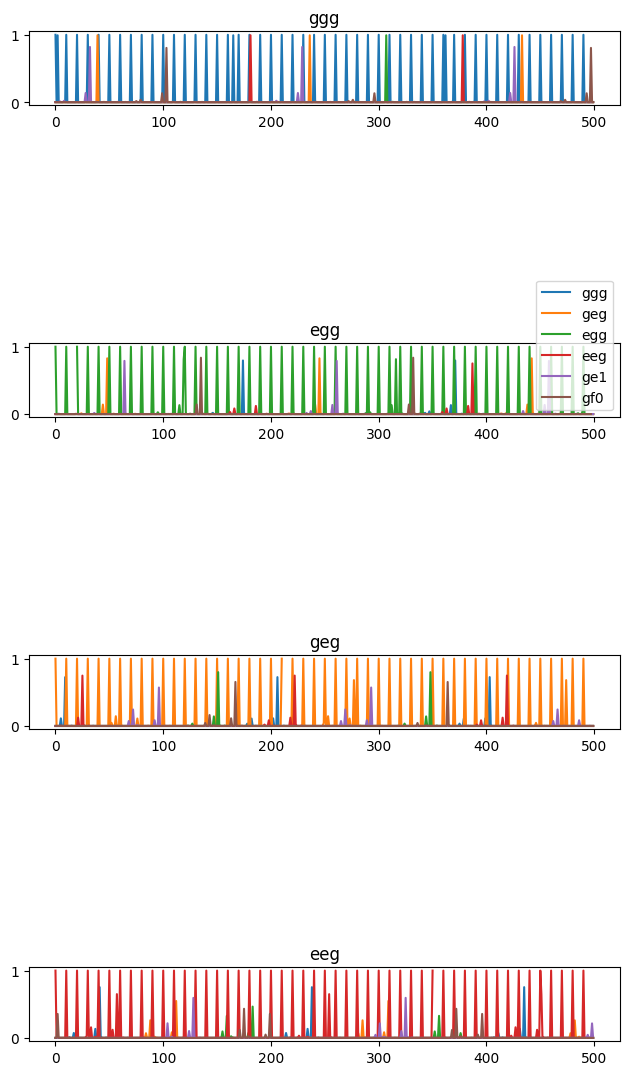

In [10]:
#make coordinate plots

for pulse, traj_dict in coords.items():
    fig, axs = plt.subplots(4,1)
    for j, init_state in enumerate(traj_dict):
        axs[j].set_title(f'{init_state}')
        for basis_state, traj in traj_dict[init_state].items():
            traj = traj[:500]
            axs[j].plot(traj*np.conj(traj), label=basis_state)
    axs[1].legend()
    fig.tight_layout()
    fig.set_figheight(12)
    fig.savefig(fname=f'{pulse}_{init_state}_trimmed.pdf')
        
    

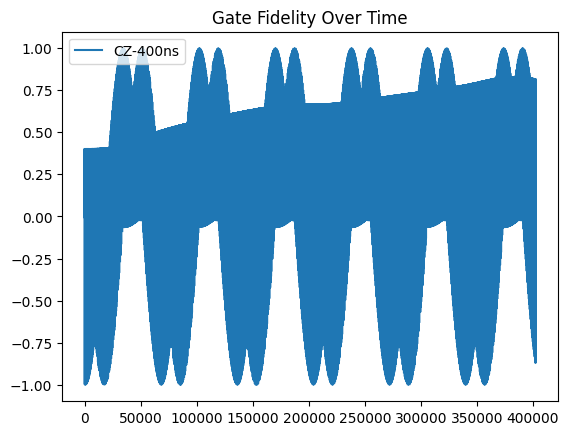

In [8]:
#make fidelity plots
fig, ax = plt.subplots()

for pulse, traj in fidelities.items():
    ax.plot(traj, label=pulse)
ax.legend()
ax.set_title('Gate Fidelity Over Time')
fig.savefig('Gate_Fidelity.pdf')
